<a href="https://colab.research.google.com/github/hallmx/DL_medical_imaging/blob/master/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted for Google Colab from [xstreamsrl Jupytemplate](https://github.com/donlelef/jupytemplate). 

In [0]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/My Drive"
base_dir = root_dir + 'Colab Notebooks/'

# Malaria Detection

Detecting P. Falciparum Malaria parasites in stained microspcopy images of RBCs.

## 

**Purpose**

To develop a DNN which can identify malaria parasites (P Falciparum) in stained blood film RBCs. 

Malaria remains a major cause of mortality and morbidity in many part of the world. It is diagnosed by visually identifying, using light microscopy, stained malaria parasites inside a patients red blood cells (RBCs) on a blood film. High rates of malaria often coincide with under-resourced healthcare environments and a lack of trained personnel to examine blood films in this way leaving many without access to malaria dignostic services. A DNN which can match human accuracy in identifying malaria parasites from blood films could provide a way to broaden malaria diagnosis to where it is needed most. 

**Methodology**

The 'Malaria cell images dataset' was downloaded from kaggle https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria. 

It contains 55, 116 images divided equally into an 'Parasitized' folder and a 'uninfected folder'

We used the Fastai2 deep learning library to train a Resnet 50 pretrained convolutional neural network (CNN) using transfer learning. Data Augmentation and progressive image resizing were used to regularize training. After 10 epochs of training with the model frozen and a further 5 epocjs unfrozen an error ate of .022 was achieved.

**Results**

Evalutaion on a held out test set of 8,267 images gave a sensitivity of 0.975, specificity of 0.980 and AUC-ROC of 0.977. The ROC curve and precision recall curve are presented in the notebook. 

These results are comparable with others and with humans trained in malaria diagnosis from blood films, demonstrating that a relatively simple DNN Model can give clinically relevant performance in malaria diagnosis. 



## Setup

Import all the required **Python** libraries

In [0]:
try:
  import fastai2.basics
except:
  !pip install fastai2
else:
  print('fastai2 already installed')

In [0]:
# General
import os, pickle
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
from random import sample, shuffle
from sklearn import metrics
from math import ceil

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Image manipulation
import PIL, cv2

# Visualizations
import matplotlib as plt
import seaborn as sns

# Matplotlib options
plt.rcParams['font.size']=14

# DL libraries
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from torch import torch

In [4]:
# check device
print("PyTorch version - ", torch.__version__)
print("Cuda version - ", torch.version.cuda)
print("cuDNN version - ", torch.backends.cudnn.version())
print("Device - ", torch.device("cuda:0"))
print("python PIL version - ", PIL.PILLOW_VERSION)

PyTorch version -  1.4.0
Cuda version -  10.1
cuDNN version -  7603
Device -  cuda:0
python PIL version -  6.2.2


## Parameter definition
Set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [0]:
SIZE = 96      # initial image size
BS = 64        # batch size
NW = 4         # num workers

## Import the dataset from Kaggle
The malaria cell images datset is hosted on Kaggle at [https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria). It can be downloaded using the Kaggle API. To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials (username and password). Use the contents of this file to access the Kaggle API as follows:

In [0]:
!pip install kaggle
api_token = # {username and password copied exactly from the downloaded kaggle.json file}
import json
# Create .kaggle directory in /root if doesn't already exist
if not os.path.exists("/root/.kaggle"):
    os.mkdir("/root/.kaggle")
    print("Directory '/root/.kaggle' created ")
else:    
    print("Directory '/root/.kaggle' already exists")
# Create kaggle.json file in .kaggle directory and then write api_token into it
with open('/root/.kaggle/kaggle.json', 'w+') as file:
  json.dump(api_token, file)
# Important - change permissions of kaggle.json so your API credentials are not exposed to other users
!chmod 600 '/root/.kaggle/kaggle.json'

In [8]:
# Download specific competition data using competition api key copied from Kaggle.com competition page
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 662M/675M [00:10<00:00, 46.8MB/s]
100% 675M/675M [00:10<00:00, 69.7MB/s]


In [9]:
# Unzip contents of a zipfile to a new folder in the current directory
import zipfile
file_zip = "cell-images-for-detecting-malaria.zip"
target_dir="malaria_dataset"
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall(target_dir)
zip_ref.close()
os.listdir("/content/"+target_dir)

['cell_images']

In [10]:
path = "/content/"+target_dir+"/cell_images"
img_path = path
os.listdir(path)

['cell_images', 'Uninfected', 'Parasitized']

In [11]:
print('Parasitised')
for f in os.listdir(path+"/Parasitized")[:5]: print(f'\t{f}')
print('Uninfected')
for f in os.listdir(path+"/Uninfected")[:5]: print(f'\t{f}')

Parasitised
	C68P29N_ThinF_IMG_20150819_134830_cell_43.png
	C180P141NThinF_IMG_20151201_170021_cell_11.png
	C126P87ThinF_IMG_20151004_104408_cell_166.png
	C116P77ThinF_IMG_20150930_171219_cell_104.png
	C116P77ThinF_IMG_20150930_171844_cell_107.png
Uninfected
	C164P125ThinF_IMG_20151116_120135_cell_129.png
	C143P104ThinF_IMG_20151005_225454_cell_145.png
	C202ThinF_IMG_20151015_151736_cell_14.png
	C101P62ThinF_IMG_20150923_170246_cell_44.png
	C109P70ThinF_IMG_20150930_102944_cell_46.png


## EDA

In [12]:
num_p=len(os.listdir(path+"/Parasitized"))
num_u=len(os.listdir(path+"/Uninfected"))

print('Data Check')
print('---------------------------')
data = {"number images": [num_p, num_u],
        "percent": [round((num_p/(num_p+num_u)*100), 2), round((num_u/(num_p+num_u)*100), 2)]}
pd.DataFrame(data, columns=["number images", "percent", ], index=["parasitized","uninfected"])

Data Check
---------------------------


,number images,percent
parasitized,13780,50.0
uninfected,13780,50.0


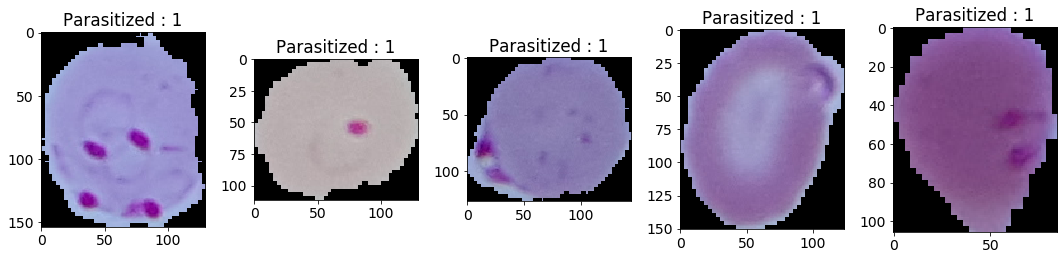

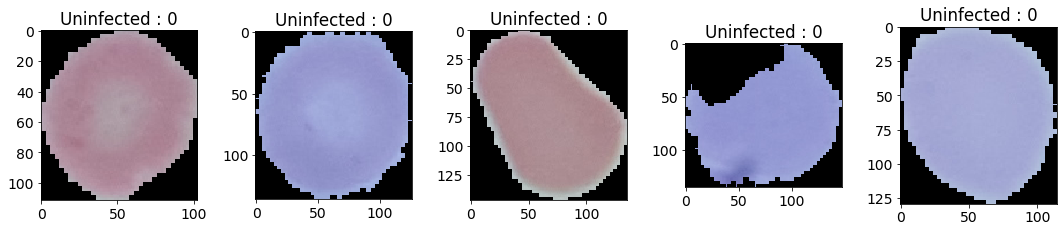

In [13]:
def show_imgs(set, s):
  plt.figure(figsize = (15,12))
  for i in range(5):
      plt.subplot(1, 5, i+1)
      img = cv2.imread(path+"/"+set+"/"+os.listdir(path+"/"+set)[i])
      plt.imshow(img)
      plt.title(f'{set} : {s}')
      plt.tight_layout()
  plt.show()

show_imgs('Parasitized', 1)
show_imgs('Uninfected', 0)

## Data processing


In [0]:
# get_image_files creates an L list of posix paths to all image files in path
images = get_image_files(path)

### Split into train and tst sets.

In [15]:
# shuffle image files then split into train (0.85) and test (0.15) sets
images = images.shuffle()
n_images = len(images)
split_at = math.ceil(n_images*0.85)
train_img, test_img = images[:split_at], images[split_at:]

def bal_ds(set):
  "Count numbers of parasitized and uninfected labels in set"
  n = [0, 0]
  for i, y in enumerate(['Parasitized', 'Uninfected']):
    n[i] = len([p for p in set if y in str(p)])
  return n[0], n[1], round(n[0]/(n[0]+n[1]), 2)

# check both train and test sets are equally balanced for both classes
x_p, x_u, x_bal = bal_ds(train_img)
print(f'Train\nParasitized: {x_p}, uninfected: {x_u}, ratio: {x_bal}')
x_p, x_u, x_bal = bal_ds(test_img)
print(f'Test\nParasitized: {x_p}, uninfected: {x_u}, ratio: {x_bal}')

Train
Parasitized: 23460, uninfected: 23389, ratio: 0.5
Test
Parasitized: 4098, uninfected: 4169, ratio: 0.5


### Get a fastai dataloader

In [0]:
# function to split train_img between train/val (0.8/0.2) randomly
split_idx = RandomSplitter()(train_img)

In [0]:
# tfms = tuple of images and labels
tfms = [[PILImage.create], [parent_label, Categorize]]

# specify item and batch level transforms (batch_tfms are executed on the GPU)
item_img_tfms = [ToTensor, FlipItem(0.5), RandomResizedCrop(SIZE, min_scale=0.35)]
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats), *aug_transforms(size=SIZE, max_rotate=30)]

In [0]:
# create the dataset from train_img paths, images and labels and split train/val 
dsets = Datasets(train_img, tfms, splits=split_idx)

In [0]:
def get_data(bs, sz):
    "return a dataloader with batch size `bs`, and image size `sz`"
    return dsets.dataloaders(bs=bs, num_workers=NW, after_item=item_img_tfms, after_batch=batch_tfms+[AffineCoordTfm(size=sz, align_corners=False)])

In [0]:
dls = get_data(BS, 96)

In [0]:
# finally the dataloader, `dls`. Start with image size 96x96
dls = get_data(BS, 96)

37480


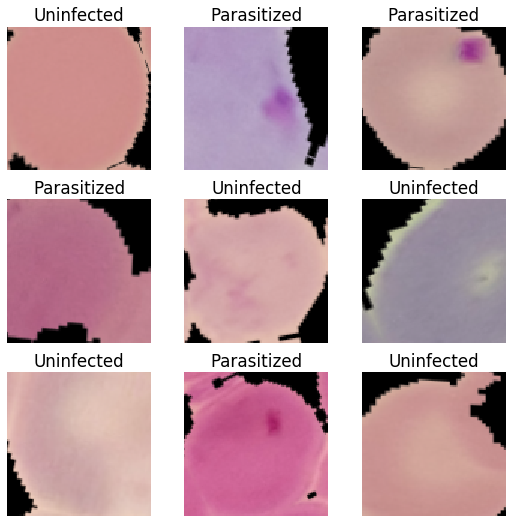

In [22]:
print(len(dls.train_ds.items))
dls.show_batch(max_n=9)

### Create a Learner. 

In [0]:
from torchvision.models import resnet50
model = resnet50

In [24]:
# get  a Learner
def get_learner():
  learn = cnn_learner(
    dls, 
    model, 
    opt_func=partial(Adam, wd=0.01, eps=1e-5), 
    cbs=[],
    metrics=error_rate, 
    config=cnn_config(ps=0.33))
  if torch.cuda.device_count() > 1: learn.to_parallel()
  return learn.to_fp16()

learn = get_learner()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


(0.005623413249850273, 1.995262391574215e-05)

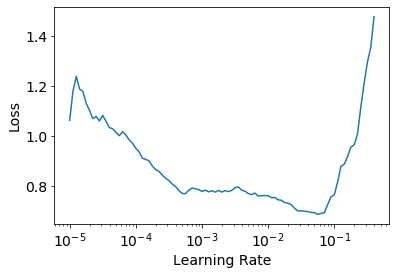

In [25]:
learn.lr_find(start_lr=1e-5, end_lr=1e-0)

epoch,train_loss,valid_loss,error_rate,time
0,0.315351,0.146562,0.051233,01:44
1,0.248715,0.142622,0.046430,01:43
2,0.220185,0.103512,0.035223,01:43
3,0.213025,0.093628,0.030846,01:43
4,0.201922,0.094857,0.031487,01:43


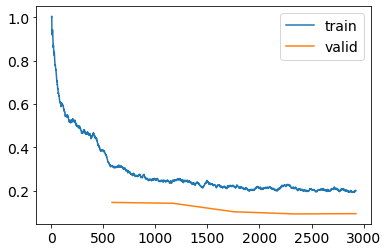

In [26]:
learn.fit_one_cycle(5, 1e-3)
learn.recorder.plot_loss()

In [0]:
# incease image size to 144x144 (progressive resizing)
learn.dls = get_data(BS, 144)

epoch,train_loss,valid_loss,error_rate,time
0,0.213064,0.128628,0.048031,01:56
1,0.200950,0.085924,0.027965,01:55
2,0.188300,0.079477,0.027217,01:55
3,0.187136,0.078008,0.025937,01:55
4,0.175276,0.077802,0.026364,01:54


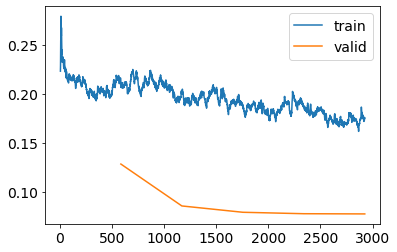

In [28]:
learn.fit_one_cycle(5, 1e-3)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,0.179336,0.081504,0.028071,02:18
1,0.180195,0.079066,0.025510,02:17
2,0.173557,0.072618,0.024336,02:19
3,0.156579,0.067870,0.021987,02:18
4,0.154124,0.068164,0.024122,02:17


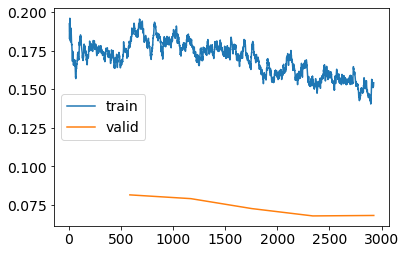

In [29]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-4, 1e-4))
learn.recorder.plot_loss()

### Test set predictions

In [30]:
dl = learn.dls.test_dl(test_img)
preds, _, targs = learn.get_preds(dl=dl, act = torch.sigmoid, with_decoded=True)

targs = np.array(targs)
len(targs), targs[:5]

(8267, array([1, 1, 1, 0, 1]))

In [31]:
labels = [1 if parent_label(o) == 'Uninfected' else 0 for o in test_img]
len(labels), labels[:5]

(8267, [1, 1, 1, 0, 1])

In [0]:
class BinClassMetrics():
  def __init__(self, y, y_hat, preds, round_to=3):
    self.y = y
    self.y_hat = y_hat
    self.preds = preds[:,1]
    self.cm = metrics.confusion_matrix(y, y_hat)
    self.round_to = round_to
    self.labels = ['Parasitized', 'Uninfected']

  def __call__(self):
    cols = ['Classifier', 'Precision', 'Recall (sensitivity)', 'F1 score', 'Sensitivity', 'Specificity', 'AUC_ROC'] 
    prf_df = self.prf_by_class
    data = ["Parasitized vs uninfected RBCs", prf_df.at[0, 'precision'], prf_df.at[0, 'recall'], prf_df.at[0, 'f1 score'], self.sensitivity, self.specificity, self.auc_roc]
    return pd.DataFrame(data, cols).T
    
  def __str__(self):
    m = metrics.classification_report(self.y, self.y_hat, digits=self.round_to)
    return m
    
  def _round(self, x): return round(x, self.round_to)

  @property
  def prf_by_class(self):
    m = metrics.precision_recall_fscore_support(self.y, self.y_hat)
    m = [[self._round(x) for x in y] for y in m]
    data = {'lesion': self.labels, 'precision': m[0], 'recall':  m[1], 'f1 score': m[2], 'support': m[3]}
    return pd.DataFrame(data)

  @property
  def sensitivity(self):
    cm = self.cm
    return self._round(cm[1,1]/(cm[1,1] + cm[1,0]))
    
  @property
  def specificity(self):
    cm = self.cm
    return self._round(cm[0,0]/(cm[0,0] + cm[0,1]))

  @property
  def auc_roc(self):
    return self._round(metrics.roc_auc_score(self.y, self.y_hat))

  @property
  def fpr_tpr(self):
    fpr, tpr, _ = metrics.roc_curve(self.y, self.preds)
    return fpr, tpr
    
  @property
  def confusion_matrix(self): 
    return self.cm

  def plot_roc(self, title='ROC curve'):
    fpr, tpr, _ = metrics.roc_curve(self.y, self.preds)
    roc = metrics.RocCurveDisplay(fpr, tpr, self.auc_roc, "")
    fig, ax = plt.subplots(figsize=(6,5))
    roc.plot(color='darkorange', lw=2, ax=ax)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
    plt.show

  def plot_pr(self, title='Precision recall curve'):
    from inspect import signature
    ap = metrics.average_precision_score(self.y, self.y_hat)
    p, r, _ = metrics.precision_recall_curve(self.y, self.preds)
    pr = metrics.PrecisionRecallDisplay(p, r, ap, "")
    fig, ax = plt.subplots(figsize=(6,5))
    pr.plot(color='darkorange', lw=2, ax=ax)
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, alpha=0.2, color='b', **step_kwargs)
    no_skill = collections.Counter(np.array(self.y_hat))[1] / len(self.y_hat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill line')
    plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
    plt.ylim([0.45, 1.02])
    plt.xlim([0.45, 1.02])
    plt.legend()
    plt.show
  
  def plot_cm(self, title='Confusion matrix'):
    cm_df = pd.DataFrame(columns=self.labels, index=self.labels, data=self.cm)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', linewidths=1, cbar=False)
    plt.xlabel("Predicted label", fontsize=16, labelpad=5)
    plt.ylabel("True label", fontsize=16, labelpad=5)
    plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
    plt.show

  

In [34]:
m = BinClassMetrics(labels, targs, preds, round_to=3)
m()

,Classifier,Precision,Recall (sensitivity),F1 score,Sensitivity,Specificity,AUC_ROC
0,Parasitized vs uninfected RBCs,0.974,0.98,0.977,0.975,0.98,0.977


In [35]:
print(m)

              precision    recall  f1-score   support

           0      0.974     0.980     0.977      4098
           1      0.980     0.975     0.977      4169

    accuracy                          0.977      8267
   macro avg      0.977     0.977     0.977      8267
weighted avg      0.977     0.977     0.977      8267



In [36]:
m.prf_by_class

,lesion,precision,recall,f1 score,support
0,Parasitized,0.974,0.980,0.977,4098
1,Uninfected,0.980,0.975,0.977,4169


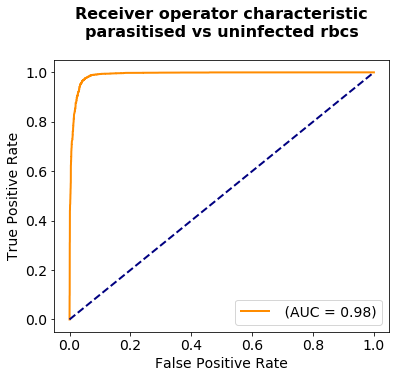

In [37]:
m.plot_roc(title="Receiver operator characteristic\nParasitised vs uninfected RBCs")

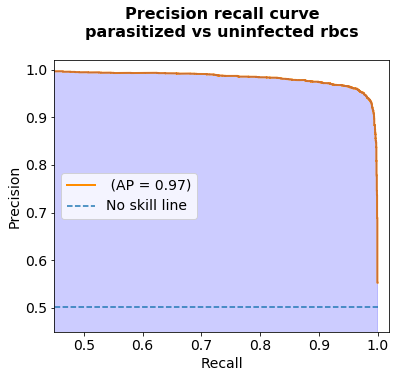

In [38]:
m.plot_pr(title='Precision recall curve\nParasitized vs uninfected RBCs')

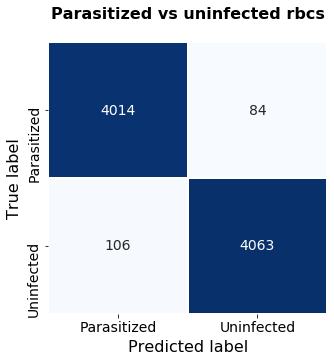

In [39]:
m.plot_cm(title='Parasitized vs uninfected RBCs')

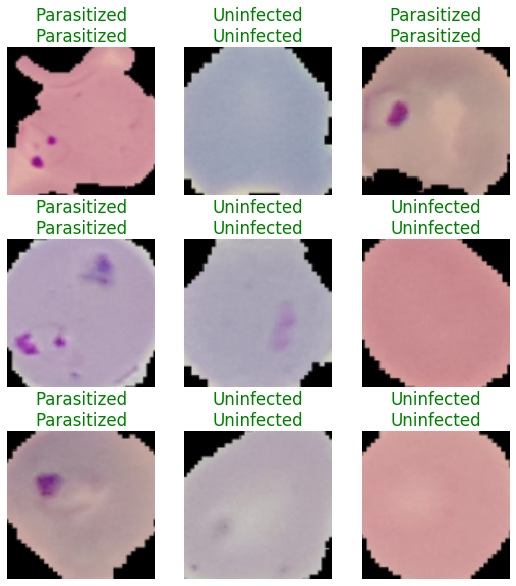

In [43]:
learn.show_results()

## References
Relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2